## Brillouin-Wigner correction of the quasiparticle Hamiltonian

We approach and analyze the structure of the corrections and the properties of these effective Hamiltonians using both the nn-pp quasiparticle and the nn-pp/ np quasiparticle frameworks.

### Get $H_Q$, $H_{RQ}$, $H_{QR}$ and $H_{RR}$ in the nn-pp framework

#### Imports

In [51]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


#### Hyperparameters of the system, select the nucleus

Set the Interaction and the subshells

In [52]:
file_name='data/cki' #select the file with the single particle energies and two-body matrix elements
# initialize the class that handles single particle states
# load the twobody matrix as a dictionary
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.61it/s]


Set the specific nucleus

In [81]:

SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a=4
nparticles_b=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'$^{12}$C'



Compute the NSM Hamiltonian

In [82]:
# initialize the nuclear shell model hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
NSMHamiltonian.get_hamiltonian()
# compute eigenvectors and eigenvalues in the active configuration interaction
eigvals_aci,eigvecs_aci=NSMHamiltonian.get_spectrum(n_states=3)

print(eigvals_aci)

print(NSMHamiltonian.hamiltonian.shape)

Building two-body operator with 1424 terms...


100%|██████████| 1424/1424 [00:00<00:00, 13059.45it/s]

✅ Two-body operator built: shape=(51, 51), nnz=1155
[-39.4534158  -35.74941099 -34.02402475]
(51, 51)


Plot the NSM Hamiltonian

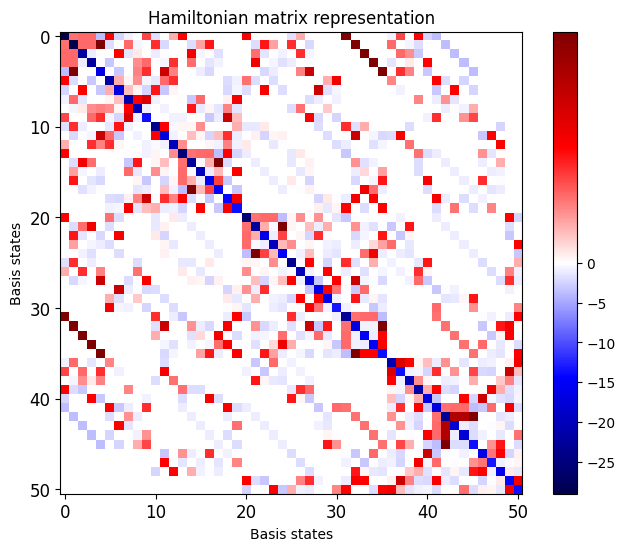

In [83]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = NSMHamiltonian.hamiltonian.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states')
plt.ylabel('Basis states')
plt.title('Hamiltonian matrix representation')
plt.show()

#### Get the Quasiparticle basis and compute the operators

In [84]:
# Initialize the quasiparticle class
QPC=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
# check the basis reduction
print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)



(9, 6)
(42, 12)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [85]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


#### Investigate the magnitude of $H_{QR}$

In [ ]:
for q_index in range(hamiltonian_qr.shape[0]):
    for r_index in range(hamiltonian_qr.shape[1]):
        if hamiltonian_qr[q_index,r_index]!=0:
            print('q_index=',q_index,' r_index=',r_index,' value=',hamiltonian_qr[q_index,r_index])
            print('\n')

Plot the Quasiparticle Hamiltonian

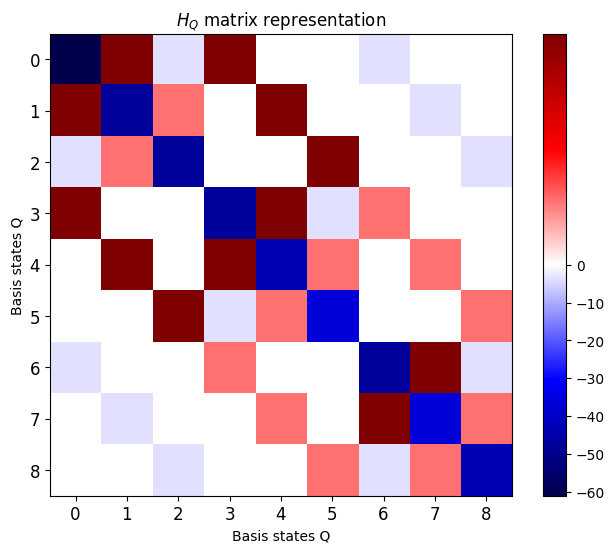

In [8]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

How many two-body operators cannot be represented as a partial quasiparticle interaction? 

In [93]:
print(QPC.couples)

[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22]]


### Get $H_Q$, $H_{RQ}$, $H_{QR}$ and $H_{RR}$ in the nn-pp/np framework

#### Imports

In [10]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverter


#### Hyperparameters of the system, select the nucleus

Set the Interaction and the subshells

In [11]:
file_name='data/cki' #select the file with the single particle energies and two-body matrix elements
# initialize the class that handles single particle states
# load the twobody matrix as a dictionary
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00, 11.19it/s]


Set the specific nucleus

In [39]:

SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a=4
nparticles_b=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'$^{10}$Be'



Compute the NSM Hamiltonian

In [40]:
# initialize the nuclear shell model hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
NSMHamiltonian.get_hamiltonian()
# compute eigenvectors and eigenvalues in the active configuration interaction
eigvals_aci,eigvecs_aci=NSMHamiltonian.get_spectrum(n_states=3)

print(eigvals_aci)

print(NSMHamiltonian.hamiltonian.shape)

Building two-body operator with 1424 terms...


100%|██████████| 1424/1424 [00:00<00:00, 16552.78it/s]

✅ Two-body operator built: shape=(51, 51), nnz=1155
[-39.4534158  -35.74941099 -34.02402475]
(51, 51)


Plot the NSM Hamiltonian

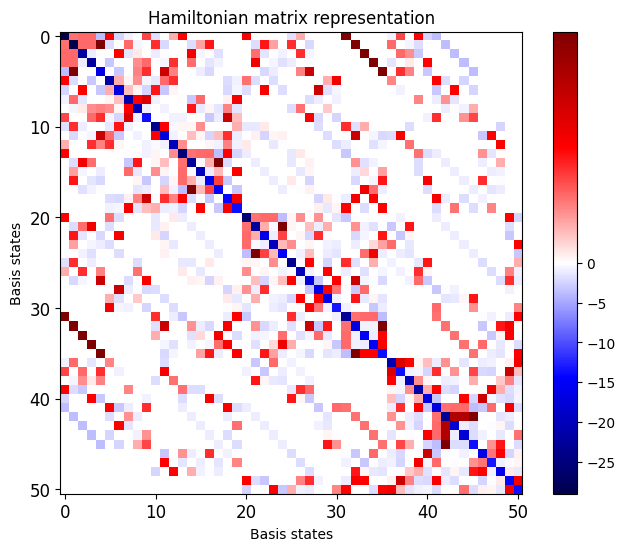

In [41]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = NSMHamiltonian.hamiltonian.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states')
plt.ylabel('Basis states')
plt.title('Hamiltonian matrix representation')
plt.show()

#### Get the Quasiparticle basis and compute the operators

In [75]:
# Initialize the quasiparticle class
QPC=QuasiParticlesConverter()
# intialize the quasiparticle modes
QPC.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
# check the basis reduction
print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)



(330, 24)
(3876, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [76]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


Plot the Quasiparticle Hamiltonian

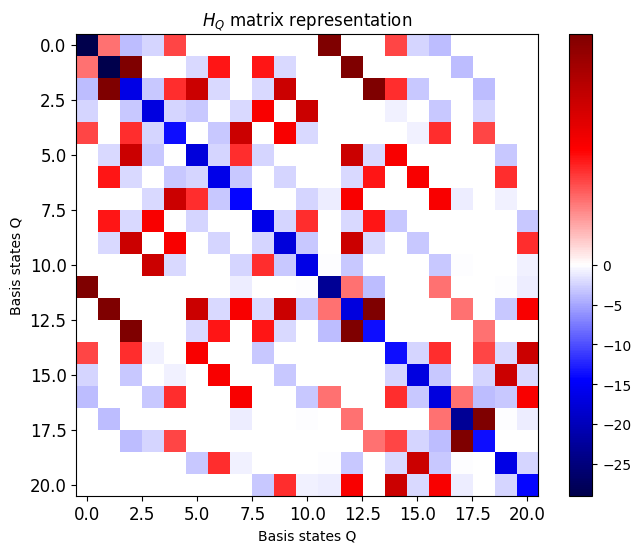

In [44]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

How many two-body operators cannot be represented as a partial quasiparticle interaction? 

In [45]:
print(QPC.couples)

[[0, 3], [1, 2], [4, 5], [6, 9], [7, 8], [10, 11], [0, 9], [1, 8], [2, 7], [3, 6], [4, 11], [5, 10]]


In [46]:
count=0
for key in twobody_matrix.keys():
    a,b,c,d=key
    
    if [min(a,b),max(a,b)] in QPC.couples or [min(c,d),max(c,d)] in QPC.couples:
        continue
    else:
        count+=1
        
print(f'Number of non quasiaparticle two-body matrix elements: {count/len(twobody_matrix)}')

Number of non quasiaparticle two-body matrix elements: 0.6685393258426966


### Exact Brillouin-Wigner method

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [86]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        #diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        #single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_full_brillouinwigner_method=[]
interaction_terms_full_brillouinwigner_method=[]
infidelities_full_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_full_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_full_brillouinwigner_method.append(1-fidelity)
    history_errors_full_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)
    

100%|██████████| 20/20 [00:00<00:00, 294.89it/s]

-39.45336293336518
1.3399268686549584e-06 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

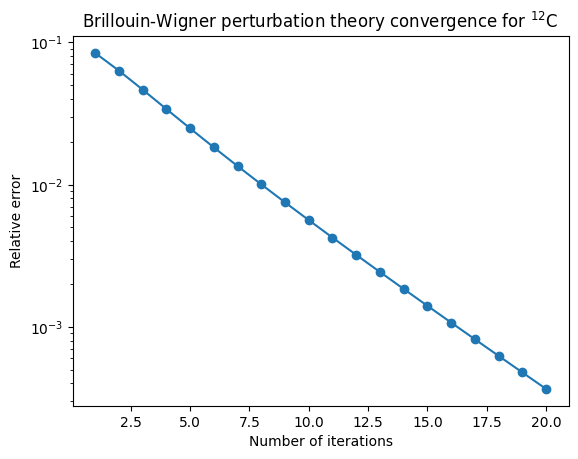

In [52]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.show()

##### Fit of the curve

Model results (lower SSE and higher R2 are better):

power (logreg):
  params: (np.float64(0.04616374061985183), np.float64(0.6294415644989002))
  SSE=2.618e-04, R2=0.7700

exp:
  params: [0.03347725 0.09871938]
  stderr: [0.00051305 0.00229815]
  SSE=8.402e-06, R2=0.9926

stretched_exp:
  params: [0.03902957 0.12174035 0.76314801]
  stderr: [0.00044491 0.00216151 0.01271891]
  SSE=4.228e-07, R2=0.9996

power*exp:
  params: [0.03470255 0.10741278 0.07861288]
  stderr: [0.00026324 0.01193152 0.00240378]
  SSE=1.498e-06, R2=0.9987


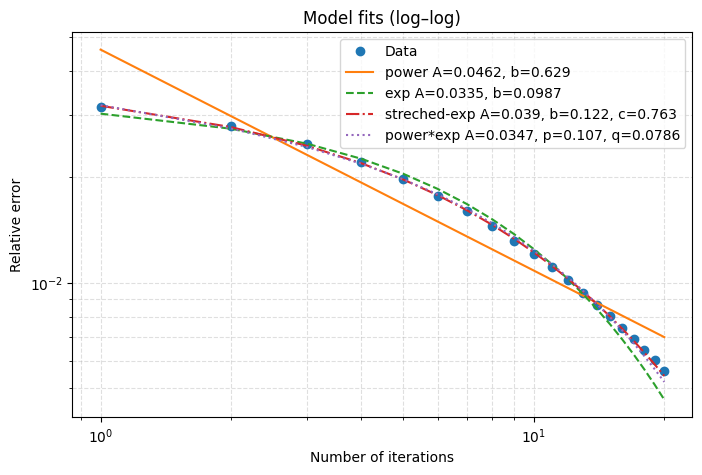

Best breakpoint (simple split) at k=5 (1-based iteration 5), total SSE=7.299e-06


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# --- data: replace with your variables ---
x = np.arange(1, nsteps_iteration + 1)
y = np.array(history_errors_full_brillouinwigner_method)

# avoid zeros or negative y when taking logs
eps = 1e-300
y = np.clip(y, eps, None)

# --- model definitions ---
def power_model(x, A, b):
    return A * x**(-b)

def exp_model(x, A, b):
    return A * np.exp(-b * x)

def stretched_exp(x, A, b, c):
    # A * exp( - (b*x)^c )
    return A * np.exp(- (b * x)**c)

def power_times_exp(x, A, p, q):
    # A * x^{-p} * exp(-q * x)
    return A * x**(-p) * np.exp(-q * x)

# --- fitting helper that wraps curve_fit with bounds and initial guesses ---
def fit_curve(model, xdata, ydata, p0=None, bounds=(-np.inf, np.inf)):
    try:
        popt, pcov = curve_fit(model, xdata, ydata, p0=p0, bounds=bounds, maxfev=100000)
        residuals = ydata - model(xdata, *popt)
        sse = np.sum(residuals**2)
        # R^2 on y (not on log) as a simple metric
        ss_tot = np.sum((ydata - np.mean(ydata))**2)
        r2 = 1 - sse / ss_tot if ss_tot > 0 else np.nan
        return popt, np.sqrt(np.diag(pcov)), sse, r2
    except Exception as e:
        print("Fit failed for", model.__name__, ":", e)
        return None, None, np.inf, np.nan

# --- Fit models ---
results = {}

# 1) Power law: fit by linear regression on log-log (more stable)
X = np.log(x)
Y = np.log(y)
slope, intercept, rval, pval, stderr = linregress(X, Y)
b_power = -slope
A_power = np.exp(intercept)
# compute sse/r2 for consistency with other fits
y_power_pred = power_model(x, A_power, b_power)
sse_power = np.sum((y - y_power_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2_power = 1 - sse_power / ss_tot
results['power (logreg)'] = ((A_power, b_power), None, sse_power, r2_power)

# 2) Exponential (nonlinear fit)
p0 = [y[0], 0.5]  # initial A and b
popt, perr, sse, r2 = fit_curve(exp_model, x, y, p0=p0, bounds=([0,0],[np.inf,np.inf]))
results['exp'] = (popt, perr, sse, r2)

# 3) Stretched exponential
# sensible initial guesses: A ~ y0, b ~ 0.5/x_mean, c ~ 1
p0 = [y[0], 0.1, 0.0]
bounds = ([0, 0, 0], [np.inf, np.inf, 5])  # restrict c to positive
popt_se, perr_se, sse_se, r2_se = fit_curve(stretched_exp, x, y, p0=p0, bounds=bounds)
results['stretched_exp'] = (popt_se, perr_se, sse_se, r2_se)

# 4) power * exponential
p0 = [y[0], 0.5, 0.1]
bounds = ([0, 0, 0], [np.inf, 5, np.inf])
popt_pe, perr_pe, sse_pe, r2_pe = fit_curve(power_times_exp, x, y, p0=p0, bounds=bounds)
results['power*exp'] = (popt_pe, perr_pe, sse_pe, r2_pe)

# --- Print results ---
print("Model results (lower SSE and higher R2 are better):")
for name, (popt, perr, sse, r2) in results.items():
    print(f"\n{name}:")
    if popt is None:
        print("  fit failed")
    else:
        print("  params:", popt)
        if perr is not None:
            print("  stderr:", perr)
        print(f"  SSE={sse:.3e}, R2={r2:.4f}")

# --- Plot data and model fits ---
plt.figure(figsize=(8,5))
plt.loglog(x, y, 'o', label='Data')

# Power-law (from logreg)
plt.loglog(x, y_power_pred, '-', label=f'power A={A_power:.3g}, b={b_power:.3g}')

# Exponential (if fit succeeded)
if results['exp'][0] is not None:
    Aexp, bexp = results['exp'][0]
    plt.loglog(x, exp_model(x, Aexp, bexp), '--', label=f'exp A={Aexp:.3g}, b={bexp:.3g}')

# Stretched exponential
if results['stretched_exp'][0] is not None:
    Ase, bse, cse = results['stretched_exp'][0]
    plt.loglog(x, stretched_exp(x, Ase, bse, cse), '-.', label=f'streched-exp A={Ase:.3g}, b={bse:.3g}, c={cse:.3g}')

# power * exp
if results['power*exp'][0] is not None:
    Ape, ppe, qpe = results['power*exp'][0]
    plt.loglog(x, power_times_exp(x, Ape, ppe, qpe), ':', label=f'power*exp A={Ape:.3g}, p={ppe:.3g}, q={qpe:.3g}')

plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title('Model fits (log–log)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# --- Optional: check for a breakpoint (simple brute-force) ---
# Try splitting the data at every candidate k and fit power-laws to left/right segments,
# pick k that minimizes total SSE.
xmin_seg = 3  # minimum points in a segment
best_k, best_sse = None, np.inf
for k in range(xmin_seg, len(x)-xmin_seg):
    # fit left (log-linear)
    xl, yl = x[:k], y[:k]
    Xl, Yl = np.log(xl), np.log(yl)
    slope_l, intercept_l, *_ = linregress(Xl, Yl)
    Al, bl = np.exp(intercept_l), -slope_l
    pred_l = power_model(xl, Al, bl)
    sse_l = np.sum((yl - pred_l)**2)
    # fit right
    xr, yr = x[k:], y[k:]
    Xr, Yr = np.log(xr), np.log(yr)
    slope_r, intercept_r, *_ = linregress(Xr, Yr)
    Ar, br = np.exp(intercept_r), -slope_r
    pred_r = power_model(xr, Ar, br)
    sse_r = np.sum((yr - pred_r)**2)
    if sse_l + sse_r < best_sse:
        best_sse = sse_l + sse_r
        best_k = k

print(f"Best breakpoint (simple split) at k={best_k} (1-based iteration {best_k}), total SSE={best_sse:.3e}")


##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

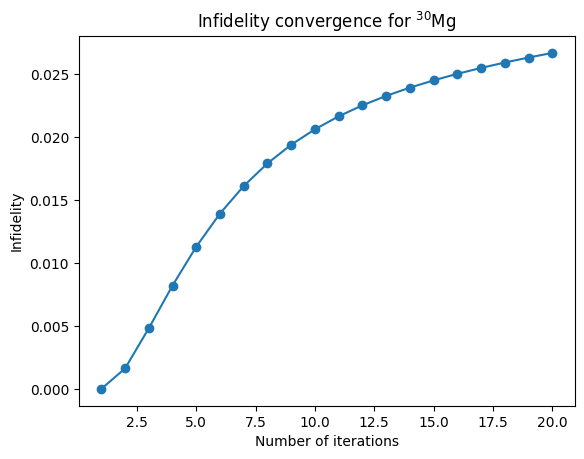

In [17]:
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [18]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_full_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.68529103]]


#### Investigate the structure and the coefficients of the $\Delta H_Q$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms_full_brillouinwigner_method[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



#### Count the N-Quasiparticle body terms

We count the flips generater by the terms of the Hamiltonian. This can indicate the non-locality of the effective Quasiparticle Hamiltonian

In [20]:
count_0=0
count_1=0
count_2=0
count_3=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_1+=1
        if np.abs(base_a-base_b).sum()==0 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_2+=1
        if np.abs(base_a-base_b).sum()==6 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_3+=1
print(count_0,count_1//2,count_2//2,count_3//2)

90 585 2070 1350


### Brillouin-Wigner method with mean field approximation of $H_{RR}$

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [12]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_meanfield_brillouinwigner_method=[]
interaction_terms_meanfield_brillouinwigner_method=[]
infidelities_meanfield_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_meanfield_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_meanfield_brillouinwigner_method.append(1-fidelity)
    history_errors_meanfield_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))

print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

100%|██████████| 20/20 [00:00<00:00, 537.05it/s]

-144.89460842720047
0.005473113393818575 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

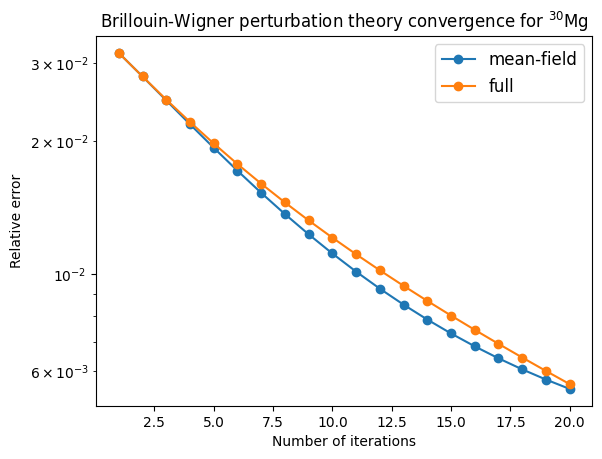

In [13]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')

plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.legend(fontsize=12)
plt.show()

##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

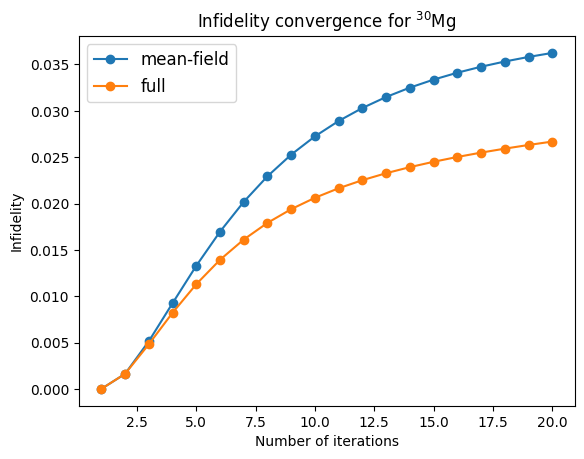

In [14]:
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o',label='full')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.legend(fontsize=12)
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [24]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_meanfield_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.63016761]]


#### Investigate the structure and the coefficients of the $\Delta H_Q$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms_meanfield_brillouinwigner_method[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



#### Count the N-Quasiparticle body terms

We count the flips generater by the terms of the Hamiltonian. This can indicate the non-locality of the effective Quasiparticle Hamiltonian

In [47]:
count_0=0
count_1=0
count_2=0
count_3=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_1+=1
        if np.abs(base_a-base_b).sum()==0 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_2+=1
        if np.abs(base_a-base_b).sum()==6 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            print(base_a,base_b,interaction_terms_full_brillouinwigner_method[-1][a,b])
            count_3+=1
print(count_0,count_1//2,count_2//2,count_3//2)

[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1.] -0.018540534917965257
[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.] 0.0010734984786942593
[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1.] -0.005603844500642632
[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.] 0.007478384085900628
[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.] 4.7860807189572154e-05
[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.] -0.0035558665971836597
[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.] 0.0016204624908473324
[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1.] -0.0004458321396077288
[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.] 0.0030977834109600488
[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.] -0.0023804921985614872
[1. 1. 0. 0. 0. 0

### Brillouin-Wigner method with mean field UNIFORM approximation of $H_{RR}$

#### First of all, we need to compute the Hartree-Fock density to get the coefficients $e_a+v_{abba} \rho_b$. Therefore, we need to compute the HF orbitals using the optimization

In [27]:
from src.hartree_fock_library import HFEnergyFunctionalNuclear
import torch
import torch.nn as nn
import torch.optim as optim


Optimize the HF orbitals using pytorch

In [28]:
# we need to get the m values in the single particle basis as a request of the HF functional model
m_values=[]
for sp in SPS.state_encoding:
    n,l,j,m,t,tz=sp
    m_values.append(m)

m_values=np.array(m_values)


# we initialize the Hartree-Fock model as a pytorch module
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a,m_values=m_values,multiplier_m_values=0)
# initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_steps = 600
# to get more info about this just go to the pytorch documentation
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        # see how it goes
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

energy_hf=energy.item()
print(energy_hf)

E1: -23.88451830904114, E2: -86.84440556015767, E_constrain: 0.0
Step    0 | Energy = -110.728924
E1: -24.328563928890873, E2: -86.97579443724969, E_constrain: 0.0
E1: -24.748593142405298, E2: -87.12724831733738, E_constrain: 0.0
E1: -25.140189026885146, E2: -87.29288181850802, E_constrain: 0.0
E1: -25.50408816014219, E2: -87.46748382615765, E_constrain: 0.0
E1: -25.845030207815853, E2: -87.64629800261753, E_constrain: 0.0
E1: -26.168009027114465, E2: -87.82512745191497, E_constrain: 0.0
E1: -26.477736641811745, E2: -88.0014938051612, E_constrain: 0.0
E1: -26.78013640179384, E2: -88.17453287060992, E_constrain: 0.0
E1: -27.081480064133135, E2: -88.34468643643577, E_constrain: 0.0
E1: -27.386851449657303, E2: -88.51334055779591, E_constrain: 0.0
E1: -27.69942223772145, E2: -88.6824235545451, E_constrain: 0.0
E1: -28.02032869578442, E2: -88.8541162840965, E_constrain: 0.0
E1: -28.34885983065602, E2: -89.03055157575291, E_constrain: 0.0
E1: -28.68282592355081, E2: -89.21350682218477, E_co

##### Now, we compute the single particle energy and we extract the diagonal to build the HF mean field Hamiltonian

-12.307151368077967 8.307496842232442


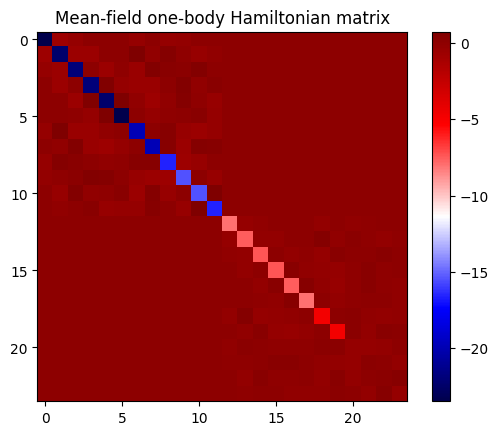

In [63]:
single_particle_energies_matrix=np.diag(SPS.energies)
# if there are protons
if nparticles_b!=0:
    one_body_energy=(torch.einsum("acbd,dc->ab", model.V_tensor, model.rho_p)+torch.einsum("acbd,ac->bd", model.V_tensor, model.rho_n)).detach().numpy()+single_particle_energies_matrix
else:
    # otherwise
    one_body_energy=(torch.einsum("acbd,ac->bd", model.V_tensor, model.rho_n))[:size_a,:size_a].detach().numpy()+single_particle_energies_matrix[:size_a,:size_a]
    
mean_onebody_energy=np.average(one_body_energy.diagonal())
std_onebody_energy=np.std(one_body_energy.diagonal())
print(mean_onebody_energy,std_onebody_energy)
plt.imshow(one_body_energy,cmap='seismic')
plt.colorbar()
plt.title('Mean-field one-body Hamiltonian matrix')
plt.show()

#### Initialize the uniform mean field $H_{RR}$ matrix

In [15]:
from scipy.sparse import lil_matrix
hamiltonian_mfhf=lil_matrix((QPC.rest_basis.shape[0],QPC.rest_basis.shape[0]))



# for r,base in enumerate(QPC.rest_basis):
#     idxs=np.nonzero(base)[0]
#     for idx in idxs:
#         gamma=np.random.uniform(-std_onebody_energy,std_onebody_energy)
#         hamiltonian_mfhf[r,r]+=mean_onebody_energy#+gamma#one_body_energy[idx,idx]

for r in range(hamiltonian_mfhf.shape[0]):
    gamma=np.random.normal(0,np.std(hamiltonian_rr.diagonal()))
    hamiltonian_mfhf[r,r]=np.average(hamiltonian_rr.diagonal())+3*gamma

    

<List of Lists sparse matrix of dtype 'float64'
	with 4116 stored elements and shape (4116, 4116)>
  Coords	Values
  (0, 0)	-100.36055755355768
  (1, 1)	-95.84270360674245
  (2, 2)	-125.52355459430889
  (3, 3)	-85.54817460688193
  (4, 4)	-94.02917343854426
  (5, 5)	-134.43381353136047
  (6, 6)	-106.10264553674789
  (7, 7)	-106.26917637035409
  (8, 8)	-109.24467110510442
  (9, 9)	-88.72196425963344
  (10, 10)	-113.53195562577442
  (11, 11)	-96.63010339375693
  (12, 12)	-108.02342733114112
  (13, 13)	-150.09565374925427
  (14, 14)	-107.84674028151778
  (15, 15)	-134.60510143219292
  (16, 16)	-115.53315257552254
  (17, 17)	-113.46939181431226
  (18, 18)	-113.86395341626195
  (19, 19)	-84.89780522480359
  (20, 20)	-117.86160379038662
  (21, 21)	-113.20609176555013
  (22, 22)	-119.2930885803693
  (23, 23)	-123.22603321621
  (24, 24)	-143.62123844198948
  :	:
  (4091, 4091)	-161.8864517260916
  (4092, 4092)	-117.55510691081612
  (4093, 4093)	-148.6627969956598
  (4094, 4094)	-110.42304501847

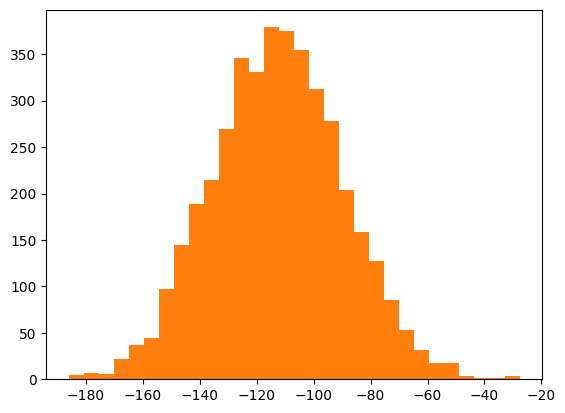

In [16]:

print(hamiltonian_mfhf)
plt.hist(hamiltonian_rr.diagonal(),bins=30)
plt.hist(hamiltonian_mfhf.diagonal(),bins=30)
plt.show()

Now, let's try to compute the correction using this effective diagonal Hamiltonian and lets see what Happens.

In [17]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_mfhf
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_meanfield_uniform_brillouinwigner_method=[]
interaction_terms_meanfield_uniform_brillouinwigner_method=[]
infidelities_meanfield_uniform_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_meanfield_uniform_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_meanfield_uniform_brillouinwigner_method.append(1-fidelity)
    history_errors_meanfield_uniform_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))

print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

100%|██████████| 20/20 [00:00<00:00, 540.29it/s]

-146.09957620070404
0.0027975383664599045 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

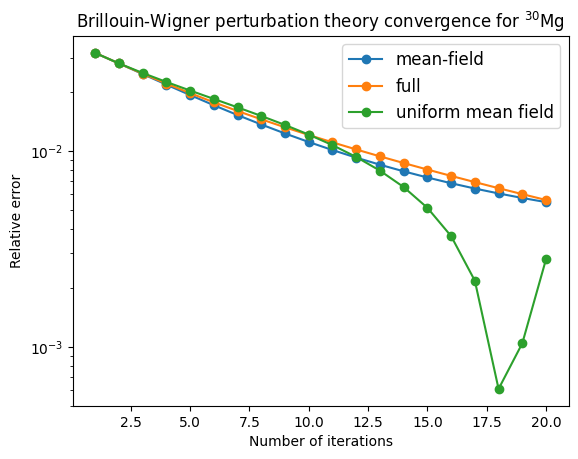

In [18]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean field')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.legend(fontsize=12)
plt.show()

##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

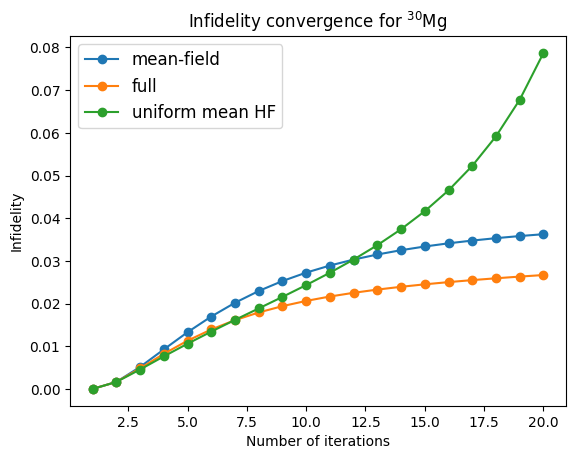

In [19]:
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o',label='full')
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean HF')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.legend(fontsize=12)
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [20]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_meanfield_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.63016761]]


Let's look at the structure of the Quasiparticle Hamiltonian

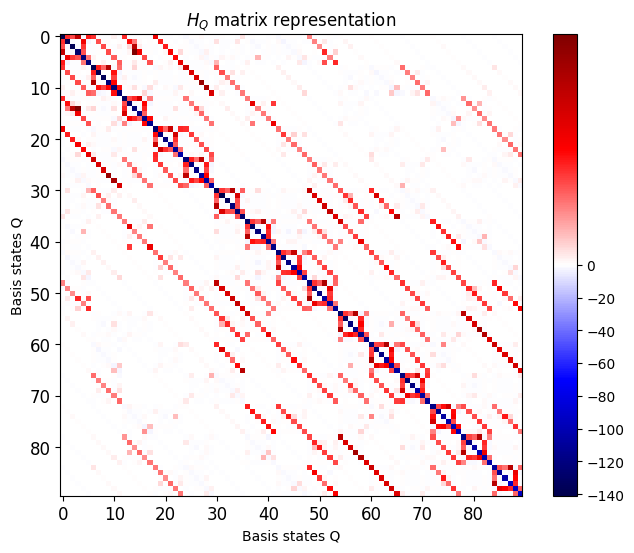

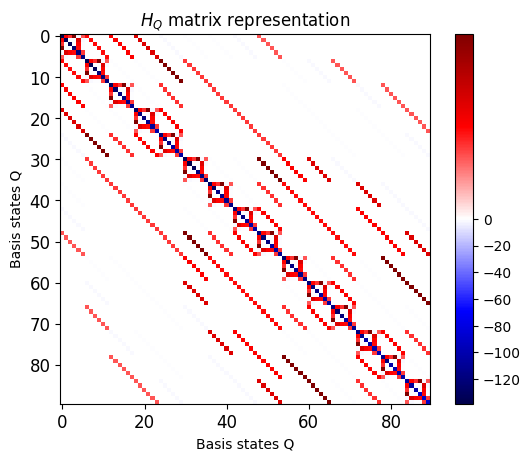

In [21]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H =hamiltonian_qq.toarray()+ interaction_terms_meanfield_uniform_brillouinwigner_method[-1].toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

# wrap the Hamiltonian in a masked array to hide zeros
H =hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

##### Plot the evolution of each element in the Hamiltonian

In [22]:
elements_vs_t=[]
index=[]
for a in range(hamiltonian_qq.shape[0]):
    for b in range(a,hamiltonian_qq.shape[0]):
        index.append([a,b])
        element=[]
        for t in range(nsteps_iteration):
            if t==0:
                element.append(hamiltonian_qq[a,b])
            else:
                element.append(hamiltonian_qq[a,b]+interaction_terms_meanfield_uniform_brillouinwigner_method[t][a,b])
        elements_vs_t.append(np.asarray(element))

elements_vs_t=np.asarray(elements_vs_t)                

In [ ]:
print(elements_vs_t.shape)
for i,a in enumerate(elements_vs_t):
    if np.abs(a[-1]-a[0])>0.1:
        print(index[i])
        plt.plot(np.arange(nsteps_iteration),a)
        plt.show()

### Using only 2-body quasiparticle connections in $H_{QR}$ for the Brillouin-Wigner Method

#### Imports

In [87]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


#### Hyperparameters of the system, select the nucleus

We need to consider the Particle subsector related to the 2-quasiparticle modes nn-pp, therefore we need to take into account the $N_n=2$ and $Z_p=2$ and $N_n=4$, $Z_p=0$

In [88]:
# 
SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a_twobody=2
nparticles_b_twobody=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'two body quasiparticle sector'



Compute the NSM Hamiltonian that corresponds to the $^{20}$ Ne

In [89]:
# initialize the nuclear shell model hamiltonian
Hamiltonian2bodysector=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a_twobody,nparticles_b=nparticles_b_twobody,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
Hamiltonian2bodysector.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
Hamiltonian2bodysector.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
Hamiltonian2bodysector.get_hamiltonian()


print(Hamiltonian2bodysector.hamiltonian.shape)

Building two-body operator with 1424 terms...


  0%|          | 0/1424 [00:00<?, ?it/s]

100%|██████████| 1424/1424 [00:00<00:00, 12789.84it/s]

✅ Two-body operator built: shape=(51, 51), nnz=1155
(51, 51)


#### Get the Quasiparticle basis and compute the operators

In [90]:
# Initialize the quasiparticle class
QPC2body=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC2body.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC2body.get_the_basis_matrix_transformation(basis=Hamiltonian2bodysector.basis)
# check the basis reduction
print(QPC2body.quasiparticle_basis.shape)
print(QPC2body.rest_basis.shape)



(9, 6)
(42, 12)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [91]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_qr_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T
hamiltonian_rq_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T


#### Investigate the magnitude of $H_{QR}$

We can check that the magnitude of the couplings of the $H_{QR}$ is similar to the $H_{QR}$ of a generic many-body hamiltonian. Maybe it's important to check the connectivity to figure out if more or less we can reduce it randomly or not.

In [ ]:
for q_index in range(hamiltonian_qr_2b.shape[0]):
    for r_index in range(hamiltonian_qr_2b.shape[1]):
        if hamiltonian_qr_2b[q_index,r_index]!=0:
            print('q_index=',q_index,' r_index=',r_index,' value=',hamiltonian_qr_2b[q_index,r_index])
            print('\n')

Create the two-body corrections using the mean field uniform $H_{RR}$ with the energy scale of the full many-body Hamiltonian. 

In [105]:
from scipy.sparse import lil_matrix
hamiltonian_rr_2body=lil_matrix((QPC.rest_basis.shape[0],QPC.rest_basis.shape[0]))

for r in range(hamiltonian_rr_2body.shape[0]):
    gamma=np.random.normal(0,np.std(hamiltonian_rr.diagonal()))
    hamiltonian_rr_2body[r,r]=np.average(hamiltonian_rr.diagonal())+gamma

Create the corrections as two-body terms to upload using the Hardcore-Boson Model

In [106]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq_2b,k=1)
e=values[0]
approximations_as_dictionary=[]
approximations_as_matrix=[]

single_term = hamiltonian_rq_2b  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_rr_2body
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr_2b @ single_term)
    twobody_quasiparticle={}
    for q,base_q in enumerate(QPC2body.quasiparticle_basis):
        for p,base_p in enumerate(QPC2body.quasiparticle_basis):
            a_q,b_q=np.nonzero(base_q)[0]
            a_p,b_p=np.nonzero(base_p)[0]
            q_max=np.max([a_q,b_q])
            q_min=np.min([a_q,b_q])
            p_max=np.max([a_p,b_p])
            p_min=np.min([a_p,b_p])
            
            if (q_max == p_max ) and (q_min == p_min) :
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]/(nparticles_a*nparticles_b/4)

            elif (q_max==p_max) and (q_min!=p_min) and (q_max < size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]/(nparticles_a/2)
            
            elif (q_max==p_max) and (q_min!=p_min) and (q_max > size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]/(nparticles_b/2)
            
            elif (q_min==p_min) and (q_max!=p_max) and (q_min < size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]/(nparticles_a/2)
            
            elif (q_min==p_min) and (q_max!=p_max) and (q_min > size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]/(nparticles_b/2)
            
            else:
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]
            
            
            
    approximations_as_dictionary.append(twobody_quasiparticle)
    approximations_as_matrix.append(update)
    


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 239.83it/s]


### Use Brillouin-Wigner with the two-body correction effect.

#### Imports

In [94]:
from NSMFermions.utils_quasiparticle_approximation import HardcoreBosonsBasis

# we introduce a class to build up quasiparticle operators on the quasiparticle basis
# it works as the FermiHubbardHamiltonian class, the only difference is the basis of the single site operator that corresponds with the S+ S- format, instead of c^dag c
HBB=HardcoreBosonsBasis(QPC.quasiparticle_basis)




We want to write the correction operators in the two-body basis as operator in this many-body basis, in this way it is possible to use them and to compare with the exact Brillouin-Wigner set of operators.

In [107]:
from tqdm import tqdm

approximations_truncated=[]

tbar=tqdm(enumerate(approximations_as_dictionary))

for _,interaction_dictionary in tbar:
    operator=0.
    tbar2=tqdm(interaction_dictionary.keys())
    for key in tbar2:
        a,b,c,d=key
        operator+=HBB.adag_adag_a_a_matrix(a,b,c,d)*interaction_dictionary[key]
    print('finished')
    approximations_truncated.append(operator)    

100%|██████████| 81/81 [00:00<00:00, 1783.28it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 2374.78it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 2007.67it/s]
3it [00:00, 21.35it/s]

finished


100%|██████████| 81/81 [00:00<00:00, 1906.63it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 1822.27it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 2056.83it/s]
6it [00:00, 20.77it/s]

finished


100%|██████████| 81/81 [00:00<00:00, 2490.15it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 2507.07it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 2283.91it/s]
9it [00:00, 22.87it/s]

finished


100%|██████████| 81/81 [00:00<00:00, 2057.51it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 1978.89it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 1776.68it/s]
12it [00:00, 22.09it/s]

finished


100%|██████████| 81/81 [00:00<00:00, 1578.05it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 1969.91it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 2252.82it/s]
15it [00:00, 21.52it/s]

finished


100%|██████████| 81/81 [00:00<00:00, 1931.25it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 1112.74it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 2249.27it/s]
18it [00:00, 20.05it/s]

finished


100%|██████████| 81/81 [00:00<00:00, 1810.84it/s]


finished


100%|██████████| 81/81 [00:00<00:00, 1925.19it/s]
20it [00:00, 20.75it/s]

finished


Here we want to compare the magnitude of the matrix elements of these corrections just to be sure that the corrections on the overcounting makes sense. The N-body terms counts only one whereas the two-body terms have a overcounting in the connection with the many-body state

In [111]:
print(approximations[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 81 stored elements and shape (9, 9)>
  Coords	Values
  (0, 5)	-0.7119446939999996
  (0, 4)	6.015003564465492
  (0, 3)	-17.940444840017896
  (0, 8)	15.23454924599999
  (0, 7)	-8.501992460499999
  (0, 6)	24.16628790823834
  (0, 2)	20.485773933394277
  (0, 1)	-11.961252721896477
  (0, 0)	40.12319605793097
  (1, 5)	15.234549245999991
  (1, 4)	-27.810990436738336
  (1, 3)	4.857289931999998
  (1, 8)	-0.7119446939999994
  (1, 7)	14.295742311517905
  (1, 6)	-9.65970609296549
  (1, 2)	-20.485773933394274
  (1, 1)	40.12319605793096
  (1, 0)	-11.961252721896475
  (2, 3)	-1.7461187334374977
  (2, 5)	-20.485773933394274
  (2, 4)	24.729745385312498
  (2, 7)	-1.7461187334374981
  (2, 8)	20.485773933394277
  (2, 6)	24.7297453853125
  (2, 2)	52.95172823749999
  :	:
  (6, 3)	-6.418295030065487
  (6, 8)	24.16628790823834
  (6, 2)	24.7297453853125
  (6, 7)	-6.418295030065491
  (6, 6)	74.71577966704348
  (6, 1)	-9.65970609296549
  (6, 0)	24.1662

<List of Lists sparse matrix of dtype 'float64'
	with 81 stored elements and shape (9, 9)>
  Coords	Values
  (0, 0)	42.60650924333274
  (0, 1)	-8.819503110548235
  (0, 2)	19.231015109878122
  (0, 3)	-9.555140239586917
  (0, 4)	6.015003564465492
  (0, 5)	-0.7119446939999996
  (0, 6)	32.55159250866932
  (0, 7)	-8.501992460499999
  (0, 8)	15.23454924599999
  (1, 0)	-8.819503110548235
  (1, 1)	54.574702283229215
  (1, 2)	-22.875717638378124
  (1, 3)	4.857289931999998
  (1, 4)	-36.19629503716932
  (1, 5)	15.234549245999991
  (1, 6)	-9.65970609296549
  (1, 7)	5.910437711086919
  (1, 8)	-0.7119446939999994
  (2, 0)	19.231015109878122
  (2, 1)	-22.875717638378124
  (2, 2)	50.65256623668097
  (2, 3)	-1.7461187334374977
  (2, 4)	24.729745385312498
  (2, 5)	-20.485773933394274
  (2, 6)	24.7297453853125
  :	:
  (6, 2)	24.7297453853125
  (6, 3)	-14.803599630496471
  (6, 4)	25.80239184580001
  (6, 5)	-9.65970609296549
  (6, 6)	48.274064525723226
  (6, 7)	-7.398329656248237
  (6, 8)	13.1981058222406


(array([1., 0., 1., 2., 0., 2., 0., 1., 2., 0., 0., 2., 0., 0., 0., 4., 0.,
        4., 2., 0., 2., 2., 4., 0., 0., 0., 2., 8., 0., 2., 4., 4., 2., 0.,
        6., 6., 4., 2., 4., 0., 0., 2., 2., 0., 0., 2., 0., 0., 0., 2.]),
 array([-1070.94592963, -1035.71526025, -1000.48459087,  -965.25392148,
         -930.0232521 ,  -894.79258272,  -859.56191333,  -824.33124395,
         -789.10057457,  -753.86990518,  -718.6392358 ,  -683.40856642,
         -648.17789703,  -612.94722765,  -577.71655827,  -542.48588889,
         -507.2552195 ,  -472.02455012,  -436.79388074,  -401.56321135,
         -366.33254197,  -331.10187259,  -295.8712032 ,  -260.64053382,
         -225.40986444,  -190.17919505,  -154.94852567,  -119.71785629,
          -84.4871869 ,   -49.25651752,   -14.02584814,    21.20482125,
           56.43549063,    91.66616001,   126.8968294 ,   162.12749878,
          197.35816816,   232.58883755,   267.81950693,   303.05017631,
          338.2808457 ,   373.51151508,   408.74218446

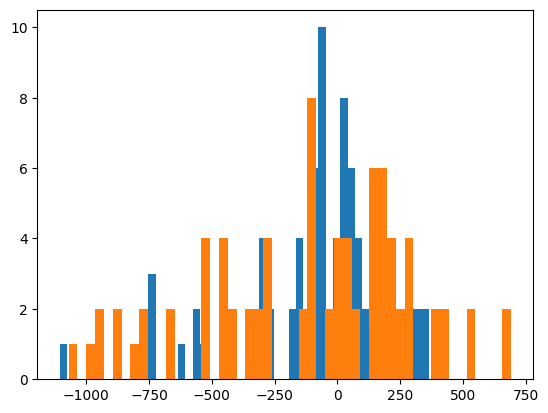

In [108]:
print(approximations_truncated[0])
# we select an iteration term
idx_iteration=0
# we compare the matrix elements of each correction using an histogram
plt.hist(approximations[1].toarray().flatten(),bins=50)
plt.hist(approximations_truncated[1].toarray().flatten(),bins=50)

#### Now we compute the iteration using this truncation, good luck

In [109]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]

    
history_errors_truncated_brillouinwigner_method=[]
interaction_terms_truncated_brillouinwigner_method=[]
infidelities_truncated_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations_truncated[j]/e**(j+1)
    interaction_terms_full_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_truncated_brillouinwigner_method.append(1-fidelity)
    history_errors_truncated_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

100%|██████████| 20/20 [00:00<00:00, 324.29it/s]

-40.95602439285397
0.03808564009990997 index= 19


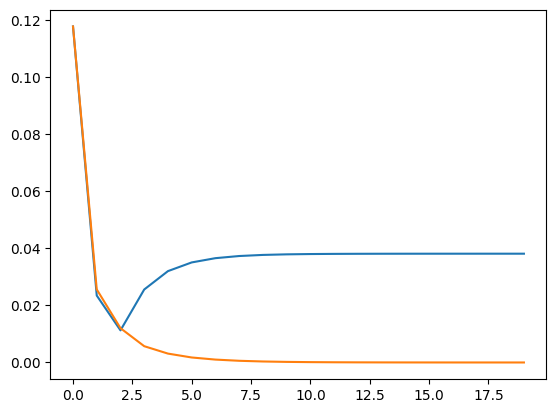

In [110]:
plt.plot(history_errors_truncated_brillouinwigner_method)
plt.plot(history_errors_full_brillouinwigner_method)
plt.show()